In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
# Building experiments configs

from fee_algorithm.fixed_fee import FixedFee
from fee_algorithm.discrete_fee_perfect_oracle import DiscreteFeePerfectOracle
from fee_algorithm.based_on_trade_count_fee import BasedOnTradeCountFee
from fee_algorithm.adaptive_fee_based_on_block_price_move import AdaptiveBasedOnPreviousBlockPriceMoveFee

from copy import deepcopy

# TODO: move to one place with historical data experiments
fee_algos_to_consider = {
    "FX_fee": FixedFee(exchange_fee_rate=0.003), # 30 bps
    "DA_fee": BasedOnTradeCountFee(a_to_b_exchange_fee_rate=0.003, b_to_a_exchange_fee_rate=0.003), # 30 bps
    "BA_fee": AdaptiveBasedOnPreviousBlockPriceMoveFee(a_to_b_exchange_fee_rate=0.003, b_to_a_exchange_fee_rate=0.003), # 30 bps
    "OB_fee": DiscreteFeePerfectOracle(fee_rate_in_arbitrage_direction=0.0045, fee_rate_in_non_arbitrage_direction=0.0015), # 45/15 bps
}

In [3]:
from experiments.experiment import SyntheticDataDescription, GBMParameters
from datetime import datetime
import numpy as np

# Provided data, see synthetic_data_example.ipynb

gbm_parameters_by_alias = {
    "volatile_market": GBMParameters(
        S0=[3406.04, 1.299e-05],
        mu=[2.6092527015913387e-07, 0.0003608078612459716],
        cov_matrix=np.array([
            [5.91363022e-07, 1.20049585e-06],
            [1.20049585e-06, 3.40028539e-05]
        ])
    ),
    "calm_market": GBMParameters(
        S0=[3179.96, 1.587e-05],
        mu=[-5.439664535383297e-06, -3.1348041846428764e-06],
        cov_matrix=np.array(
            [[1.62154349e-06, 1.31591401e-06],
            [1.31591401e-06, 1.92476086e-06]]
        )
    ),
    "bull_market": GBMParameters(
        S0=[2518.75, 1.751e-05],
        mu=[8.82932404942772e-06, 1.0120694501213374e-05],
        cov_matrix=np.array(
            [[1.04648385e-06, 1.37680192e-06],
            [1.37680192e-06, 4.61054708e-06]]
        )
    ),
    "bear_market": GBMParameters(
        S0=[3539.93, 2.858e-05],
        mu=[-3.5843786641630628e-06, -4.891135343153541e-06],
        cov_matrix=np.array(
            [[9.69680101e-07, 1.32425664e-06],
            [1.32425664e-06, 3.19313094e-06]]
        )
    )
}

# Time range is used only to estimate number of "blocks" in simulation, so all time ranges are exactly 24 hours
time_range_by_alias = {
    "volatile_market": (datetime(2024, 3, 1, 12, 0, 0), datetime(2024, 3, 2, 12, 0, 0)),
    "calm_market": (datetime(2024, 8, 1, 12, 0, 0), datetime(2024, 8, 2, 12, 0, 0)),
    "bull_market": (datetime(2024, 11, 1, 12, 0, 0), datetime(2024, 11, 2, 12, 0, 0)),
    "bear_market": (datetime(2024, 4, 1, 12, 0, 0), datetime(2024, 4, 2, 12, 0, 0)),
}

synthetic_data_description_by_alias = {
    alias: SyntheticDataDescription(
        gbm_parameters=gbm_parameters_by_alias[alias],
        start_time=time_range_by_alias[alias][0],
        end_time=time_range_by_alias[alias][1],
    ) for alias in gbm_parameters_by_alias.keys()
}

random_seeds = [i for i in range(1000)]

In [4]:
from experiments.experiment import Experiment
from experiments.configs import DEFAULT_UNINFORMED_USERS_CONFIG
from user.informed_user import InformedUser
from experiments.run_multiple_experiments import run_multiple_experiments, get_experiment_key

# build experiments config

experiments_configs = {}

for fee_algo_name, fee_algo in fee_algos_to_consider.items():
    for data_alias, synthetic_data_description in synthetic_data_description_by_alias.items():
        for random_seed in random_seeds:
            experiments_configs[
                get_experiment_key({
                    "data_alias": data_alias,
                    "fee_algo_name": fee_algo_name,
                    "random_seed": str(random_seed),
                })
            ] = Experiment(
                data=synthetic_data_description, 
                fee_algorithm=deepcopy(fee_algo),
                informed_user=InformedUser(),
                uninformed_users=deepcopy(DEFAULT_UNINFORMED_USERS_CONFIG),
                random_seed=random_seed,
            )

print(
    f"Total experiments to run: {len(experiments_configs)}"
)

Total experiments to run: 16000


In [5]:
experiments_results = run_multiple_experiments(
    experiments_configs,
    parallel=True,
    max_workers=16,
    return_intermediate_results=False,
)

Running Experiments: 100%|██████████| 16000/16000 [05:36<00:00, 47.58it/s]


In [6]:
from visualizations.compare_fee_algoritms import get_experiments_summary_by_description

df = get_experiments_summary_by_description(
    experiments_results
)

In [7]:
df

,data_alias,fee_algo_name,random_seed,iu_markout,iu_trade_count,iu_yield,uu_markout,uu_trade_count,uu_yield,lp_markout,lp_yield,impermanent_loss
0,volatile_market,FX_fee,0,72088.04,706,31.75,-7605.94,743,-48.98,-71727.10,-29.57,86871.67
1,volatile_market,FX_fee,2,88193.43,714,33.62,-9461.41,761,-53.75,-86107.02,-30.76,3621769.83
2,volatile_market,FX_fee,1,97402.37,759,32.69,-8678.48,708,-49.55,-96058.89,-30.45,2249964.03
3,volatile_market,FX_fee,7,82160.18,726,32.33,-8247.90,723,-50.44,-81157.28,-30.00,986180.08
4,volatile_market,FX_fee,3,70844.16,721,32.30,-8113.68,739,-56.61,-70030.48,-29.97,-71726.87
...,...,...,...,...,...,...,...,...,...,...,...,...
15995,bear_market,OB_fee,994,999.66,117,7.02,-7568.73,686,-58.53,2554.07,9.40,14383.99
15996,bear_market,OB_fee,996,916.49,104,6.89,-8283.13,733,-55.83,3181.63,11.31,-5080.74
15997,bear_market,OB_fee,997,827.18,99,6.85,-8110.15,739,-56.83,3092.97,11.74,-3776.07
15998,bear_market,OB_fee,998,725.01,89,6.58,-7919.21,702,-55.61,3239.19,12.82,-4527.39


In [8]:
import pandas as pd
from typing import Optional

def show_stats_for_data_alias(data_alias, path_to_save: Optional[str] = None):
    df_filtered = df[df['data_alias'] == data_alias]


    grouped_stats = df_filtered.drop(columns=["data_alias", "random_seed"]).groupby('fee_algo_name').agg(['mean', 'std'])

    formatted_stats = grouped_stats.apply(
        lambda row: [f"{row[col, 'mean']:.2f} ± {row[col, 'std']:.2f}" for col in grouped_stats.columns.levels[0]],
        axis=1
    )

    formatted_stats_df = pd.DataFrame(formatted_stats.tolist(), columns=grouped_stats.columns.levels[0], index=grouped_stats.index)

    formatted_stats_df.reset_index(inplace=True)

    display(formatted_stats_df)

    if path_to_save:
        formatted_stats_df.to_csv(path_to_save, index=False)



In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

def plot_yield_stats(data_alias: str, fee_algos: Optional[list[str]] = None):
    df_filtered = df[df['data_alias'] == data_alias]
    fee_algos = fee_algos or df_filtered['fee_algo_name'].unique()  # type: ignore
    colors = sns.color_palette("husl", len(fee_algos))

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.set(style="whitegrid")

    for color, fee_algo_name in zip(colors, fee_algos):
        data = df_filtered[df_filtered['fee_algo_name'] == fee_algo_name]['lp_yield']
        mean = data.mean()
        sem = stats.sem(data)
        ci_low, ci_high = stats.t.interval(0.95, len(data) - 1, loc=mean, scale=sem)

        # Plot the KDE and track the latest line
        line_objs_before = len(ax.lines)
        sns.kdeplot(data, color=color, linewidth=2, ax=ax, label=f"{fee_algo_name} (Avg: {mean:.2f} bps)")
        line_objs_after = len(ax.lines)

        # Extract the newest line data
        new_line = ax.lines[line_objs_after - 1]
        x_vals, y_vals = new_line.get_data()
        x_vals = np.array(x_vals)
        y_vals = np.array(y_vals)

        ax.axvspan(
            ci_low, ci_high,
            color=color,
            alpha=0.2,
            label=f"{fee_algo_name} 95% CI {ci_low:.2f} - {ci_high:.2f}"
        )

        # Plot vertical line at mean
        ax.axvline(mean, color=color, linestyle='--', linewidth=1.5)

    ax.set_xlabel("LP Yield, bps", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.set_title(f"KDE Curves for {data_alias}", fontsize=14, weight='bold')
    ax.legend(title="Fee Algorithm", fontsize=10, title_fontsize=11)
    plt.tight_layout()
    plt.show()

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_performance_profile(data_alias: str, fee_algos: Optional[list[str]] = None):
    """
    Plots a performance profile comparing different algorithms.

    Parameters:
    - problem_cols: list of column names identifying each problem instance (e.g. ['data_alias', 'random_seed'])
    - algo_col: column name of the algorithm (e.g. 'fee_algo_name')
    - metric_col: column name of the performance metric (e.g. 'lp_yield')
    - maximize: True if higher metric is better, False if lower is better
    """
    fee_algos = fee_algos or df['fee_algo_name'].unique() # type: ignore
    
    df_filtered = df[df['data_alias'] == data_alias]
    df_filtered = df_filtered[df_filtered['fee_algo_name'].isin(fee_algos)] # type: ignore
    
    df_filtered["metric"] = df_filtered["lp_yield"]
    pivot_df = df_filtered.pivot(index="random_seed", columns="fee_algo_name", values="metric")

    pivot_df = -pivot_df

    best_perf = pivot_df.min(axis=1)
    ratios = pivot_df.divide(best_perf, axis=0)

    taus = np.linspace(ratios.min().min(), ratios.max().max(), 500)
    profile = {
        algo: [(ratios[algo] <= tau).mean() for tau in taus]
        for algo in ratios.columns
    }

    # Plotting
    plt.figure(figsize=(10, 6))
    for algo, values in profile.items():
        plt.plot(taus, values, label=algo)

    plt.xlabel("Performance Ratio τ")
    plt.ylabel("Proportion of Problems")
    plt.title(f"Performance Profile for {data_alias}, metric: lp_yield")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

,fee_algo_name,iu_markout,iu_trade_count,iu_yield,uu_markout,uu_trade_count,uu_yield,lp_markout,lp_yield,impermanent_loss
0,BA_fee,84717.29 ± 8414.19,730.76 ± 20.55,32.70 ± 0.95,-8769.63 ± 588.63,719.21 ± 19.23,-53.64 ± 2.89,-83197.47 ± 8168.15,-30.20 ± 0.94,1273048.31 ± 1222315.45
1,DA_fee,85732.93 ± 8441.84,733.76 ± 20.52,32.83 ± 0.94,-8780.55 ± 600.95,719.05 ± 19.09,-53.71 ± 2.91,-84216.41 ± 8189.10,-30.35 ± 0.94,1276428.63 ± 1223596.86
2,FX_fee,85640.18 ± 8477.36,733.52 ± 20.56,32.82 ± 0.94,-8768.77 ± 611.06,718.93 ± 19.32,-53.64 ± 2.91,-84133.68 ± 8222.04,-30.34 ± 0.94,1275484.21 ± 1223233.44
3,OB_fee,69766.64 ± 7414.82,596.71 ± 20.93,32.85 ± 1.04,-8804.84 ± 563.87,719.27 ± 18.86,-53.85 ± 2.76,-67541.67 ± 7193.84,-29.52 ± 1.06,1256551.09 ± 1221397.47


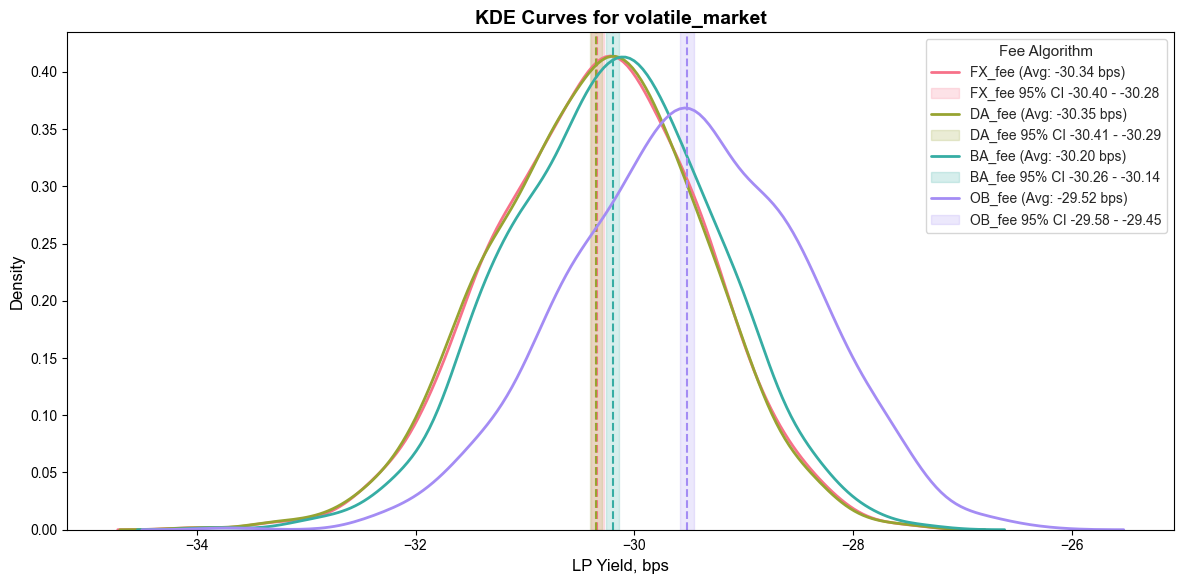

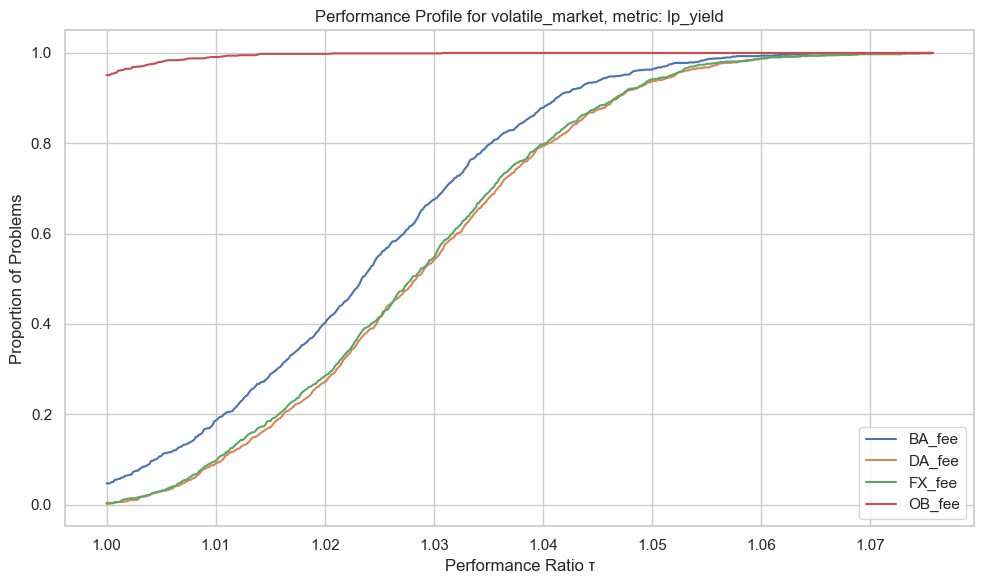

In [11]:
# Volatile Market

show_stats_for_data_alias(
    "volatile_market",
    "artifacts/synthetic_data/volatile_market_stats.csv"
)

plot_yield_stats(
    "volatile_market",
    fee_algos=None
)

plot_performance_profile(
    "volatile_market",
    fee_algos=None
)

,fee_algo_name,iu_markout,iu_trade_count,iu_yield,uu_markout,uu_trade_count,uu_yield,lp_markout,lp_yield,impermanent_loss
0,BA_fee,588.96 ± 100.80,92.79 ± 11.43,5.51 ± 0.47,-8111.19 ± 281.28,719.31 ± 18.71,-56.83 ± 1.20,3461.73 ± 223.86,13.94 ± 1.30,-3455.53 ± 5306.40
1,DA_fee,595.12 ± 103.93,95.57 ± 12.23,5.43 ± 0.45,-8118.47 ± 283.12,719.15 ± 18.92,-56.90 ± 1.22,3449.75 ± 232.01,13.76 ± 1.40,-3420.03 ± 5709.11
2,FX_fee,595.07 ± 103.25,94.84 ± 11.80,5.46 ± 0.46,-8115.92 ± 284.46,719.38 ± 18.89,-56.86 ± 1.16,3449.77 ± 225.83,13.78 ± 1.32,-3429.50 ± 5533.93
3,OB_fee,433.70 ± 92.90,68.95 ± 11.57,5.47 ± 0.53,-8118.36 ± 278.53,719.51 ± 18.82,-56.87 ± 1.10,3742.36 ± 224.49,16.96 ± 1.65,-3740.13 ± 5480.56


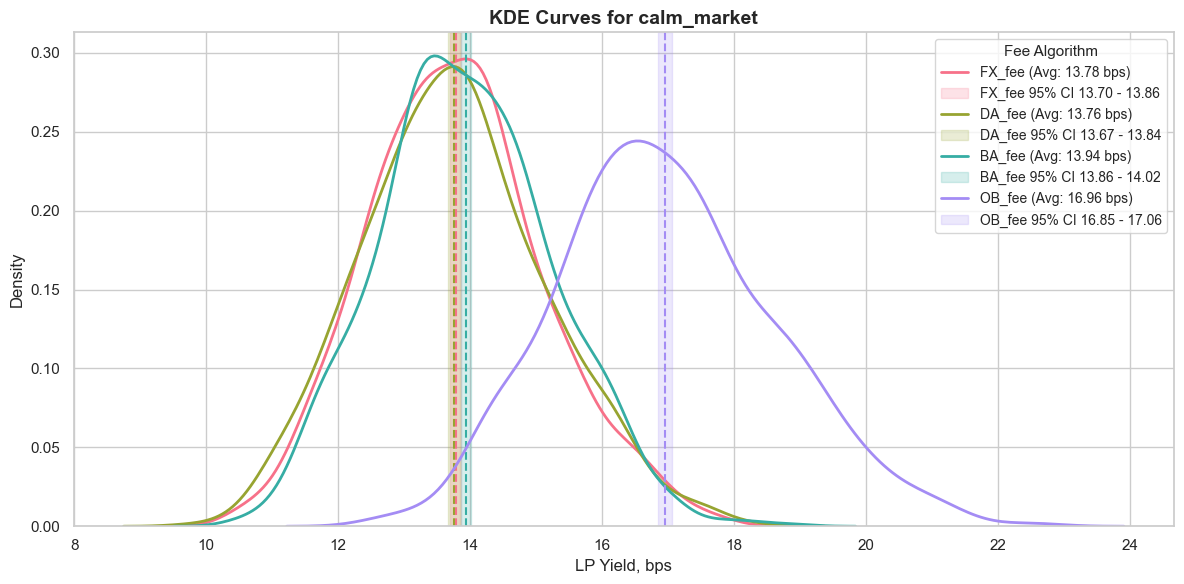

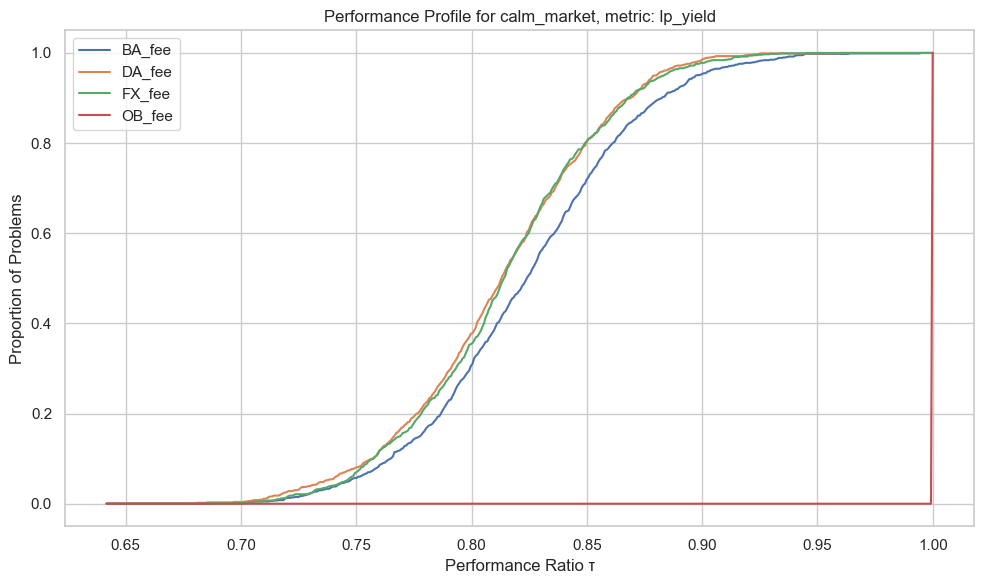

In [12]:
# Calm Market

show_stats_for_data_alias(
    "calm_market",
    "artifacts/synthetic_data/calm_market_stats.csv"
)

plot_yield_stats(
    "calm_market",
    fee_algos=None
)

plot_performance_profile(
    "calm_market",
    fee_algos=None
)

,fee_algo_name,iu_markout,iu_trade_count,iu_yield,uu_markout,uu_trade_count,uu_yield,lp_markout,lp_yield,impermanent_loss
0,BA_fee,2903.42 ± 339.54,210.90 ± 15.95,9.56 ± 0.53,-8159.49 ± 307.34,719.20 ± 19.32,-56.65 ± 1.37,605.55 ± 401.15,1.39 ± 0.95,726.29 ± 20296.91
1,DA_fee,3001.12 ± 343.54,216.36 ± 16.65,9.60 ± 0.50,-8159.26 ± 311.09,718.96 ± 19.05,-56.67 ± 1.42,481.55 ± 410.48,1.10 ± 0.95,904.30 ± 21066.28
2,FX_fee,2976.37 ± 341.09,215.04 ± 16.43,9.59 ± 0.50,-8150.08 ± 316.68,719.37 ± 19.56,-56.57 ± 1.38,501.65 ± 406.64,1.15 ± 0.94,863.98 ± 20738.34
3,OB_fee,2206.80 ± 311.67,159.40 ± 16.19,9.58 ± 0.59,-8159.60 ± 291.05,719.66 ± 18.73,-56.61 ± 1.30,1557.48 ± 389.04,4.24 ± 1.27,-201.89 ± 20698.47


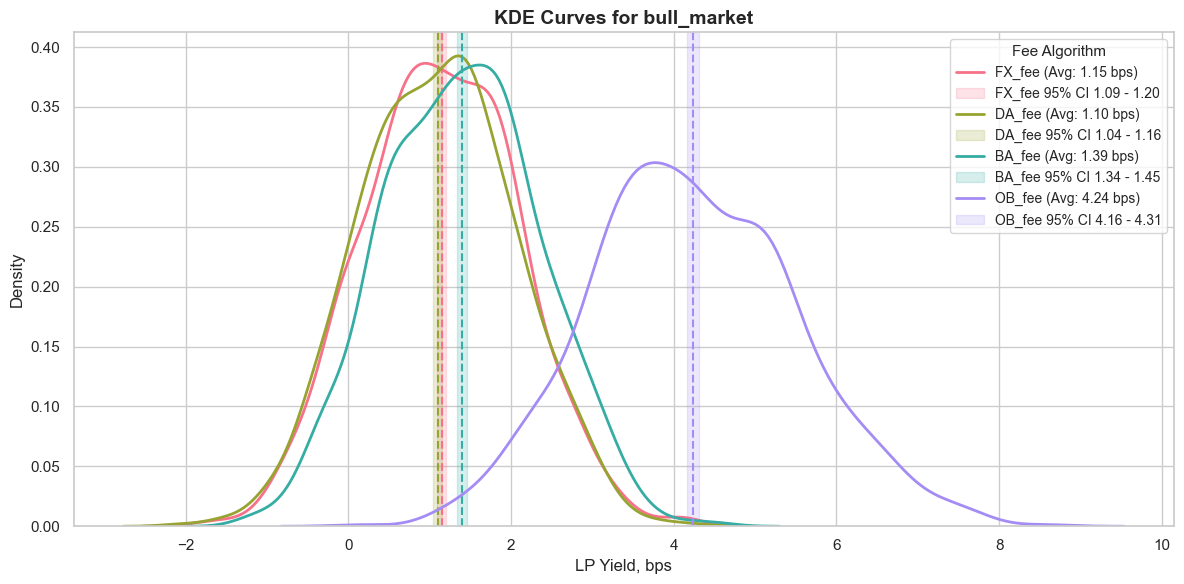

In [13]:
# Bull Market

show_stats_for_data_alias(
    "bull_market",
    "artifacts/synthetic_data/bull_market_stats.csv"
)

plot_yield_stats(
    "bull_market",
    fee_algos=None
)

,fee_algo_name,iu_markout,iu_trade_count,iu_yield,uu_markout,uu_trade_count,uu_yield,lp_markout,lp_yield,impermanent_loss
0,BA_fee,1163.63 ± 164.95,133.86 ± 13.18,6.95 ± 0.49,-8113.00 ± 293.60,719.15 ± 18.89,-56.86 ± 1.30,2684.36 ± 266.24,8.72 ± 1.16,-2008.29 ± 10117.17
1,DA_fee,1197.87 ± 170.21,138.18 ± 13.92,6.94 ± 0.48,-8125.04 ± 292.16,719.40 ± 19.03,-56.93 ± 1.32,2639.29 ± 281.29,8.44 ± 1.22,-1922.34 ± 10678.76
2,FX_fee,1192.67 ± 169.81,137.09 ± 13.91,6.96 ± 0.47,-8116.28 ± 294.45,719.57 ± 19.02,-56.85 ± 1.27,2640.31 ± 280.54,8.47 ± 1.21,-1949.61 ± 10442.02
3,OB_fee,872.16 ± 158.09,100.03 ± 13.72,6.96 ± 0.55,-8105.17 ± 288.14,718.86 ± 19.14,-56.83 ± 1.14,3138.54 ± 278.07,11.82 ± 1.59,-2448.72 ± 10393.04


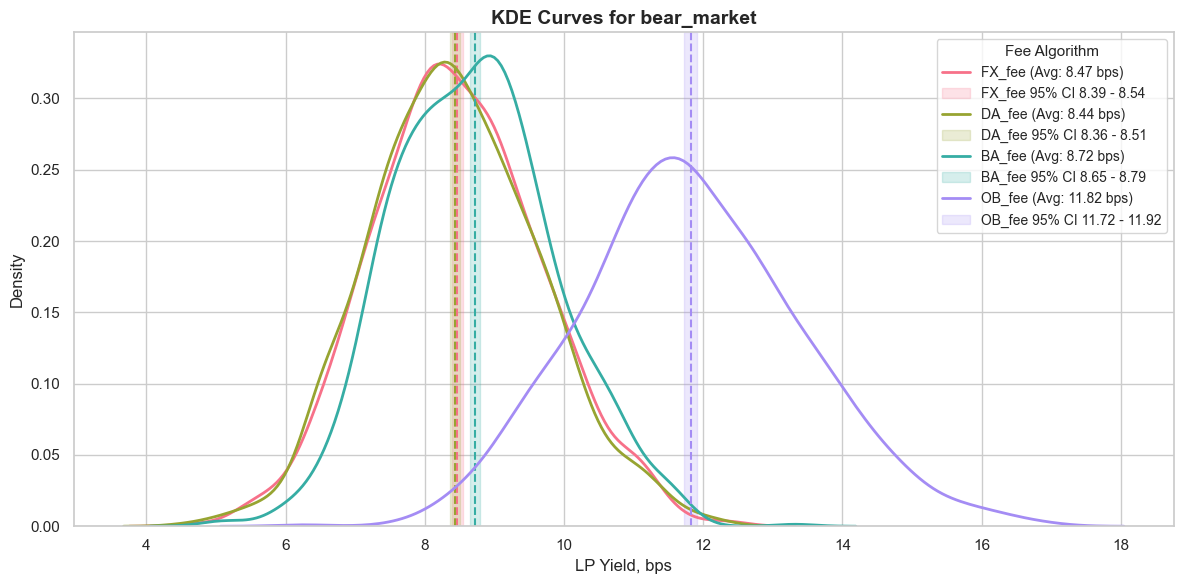

In [14]:
# Bear Market

show_stats_for_data_alias(
    "bear_market",
    "artifacts/synthetic_data/bear_market_stats.csv"
)

plot_yield_stats(
    "bear_market",
    fee_algos=None
)